# Spam prediction using Class Vectorizer and TF-IDF as means for Natural Language Processing (NLP), and Naive-Bayes Machine Learning Classifier Method.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import string
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import auc, plot_roc_curve, classification_report, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

**The data is downloaded from UCI (University of Calivornia, Irvine) Machine Learning Repository. The data is some YouTube viewers' comments in 2017 of a music video from South Korean pop artist, Psy. The comments can be classified as spam and not spam. Text of the spam comments most likely are not related to the video. Spam comments are mostly the way of users to lead viewers to visit the link of their website.**

**Link for the dataset: https://archive.ics.uci.edu/ml/datasets/YouTube+Spam+Collection**

### Exploratory Data Analysis

In [3]:
psy = pd.read_csv('Youtube01-Psy.csv')

In [4]:
psy.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1


**CLASS shows the classification of the comment (['CONTENT']).**

**Class 1 = spam.**

**Class 0 = not spam.**

In [5]:
psy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  350 non-null    object
 1   AUTHOR      350 non-null    object
 2   DATE        350 non-null    object
 3   CONTENT     350 non-null    object
 4   CLASS       350 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 13.8+ KB


In [6]:
psy['AUTHOR']

0                                 Julius NM
1                               adam riyati
2                          Evgeny Murashkin
3                           ElNino Melendez
4                                    GsMega
                       ...                 
345                         Carmen Racasanu
346                         diego mogrovejo
347    BlueYetiPlayz -Call Of Duty and More
348                            Photo Editor
349                              Ray Benich
Name: AUTHOR, Length: 350, dtype: object

**To check whether the timestamp is related to the comment classification or not, first the DATE column has to be converted to datetime format.**

In [7]:
psy['DATE'] = pd.to_datetime(psy['DATE'], format='%Y-%m-%dT%H:%M:%S')

In [8]:
psy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   COMMENT_ID  350 non-null    object        
 1   AUTHOR      350 non-null    object        
 2   DATE        350 non-null    datetime64[ns]
 3   CONTENT     350 non-null    object        
 4   CLASS       350 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 13.8+ KB


**We can get information about the comment length.**

In [9]:
psy['CON_LEN'] = psy['CONTENT'].apply(len)

# I think there's an indication that greater length of author's characters tend to belong to spammer account.
psy['AUT_LEN'] = psy['AUTHOR'].apply(len) 

psy.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CON_LEN,AUT_LEN
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07 06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,9
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07 12:37:15,Hey guys check out my new channel and our firs...,1,166,11
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08 17:34:21,just for test I have to say murdev.com,1,38,16
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09 08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48,15
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10 16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39,6


**Comment with maximum length.**

In [10]:
psy[psy['CON_LEN']==max(psy['CON_LEN'])]

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CON_LEN,AUT_LEN
303,z12cehoxozfgg3nok04cjj05xznbgrlpfjo,Elieo Cardiopulmonary,2014-11-08 15:29:52,im sorry for the spam but My name is Jenny. I ...,1,1078,21


In [11]:
psy[psy['CON_LEN']==max(psy['CON_LEN'])]['CONTENT'].values[0]

"im sorry for the spam but My name is Jenny. I go to high school where  everyone dresses fashionable but for me I don't because i need money to buy  cute clothes. I have low self esteem . I live with my dad. my mom passed  away when i was 6 so i don't really have a mother figure. I have 2 brothers  who is older than me. Since they are boys they get the attention while i  just be alone. I really want to wear pretty clothes like the girls in my  school and get a boyfriend. i just can't be my self. im very quite and shy  at school because i don't have the confidence in myself to talk to someone.  i did have one friend name Caroline but she moved away so now im alone. if  you could donate some money to me it would be great. i don't care about  expensive brand ill just shop at walmart because they have pretty clothes.  also i wanna get my nails done at a salon . i see alot of girls have these  french tips. i never had my nail did at a salon before i will really  appreciate if i can and get 

**Comment with minimum length.**

In [12]:
psy[psy['CON_LEN']==min(psy['CON_LEN'])]

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CON_LEN,AUT_LEN
263,z122ybty1la4dbrz304cgnoh1knkiv0odfg,bruno jovao,2014-11-08 04:51:38,LoL﻿,0,4,11


In [13]:
psy[psy['CON_LEN']==min(psy['CON_LEN'])]['CONTENT'].values[0]

'LoL\ufeff'

**Comment length data distribution.**

In [14]:
plt.rcParams['patch.force_edgecolor']=True
plt.rcParams['axes.grid']=True
plt.rcParams['grid.alpha']=0.4

*We can see the difference of the distribution of spam comment length, and not spam comment length. Spam comment tends to have greater lengths.*

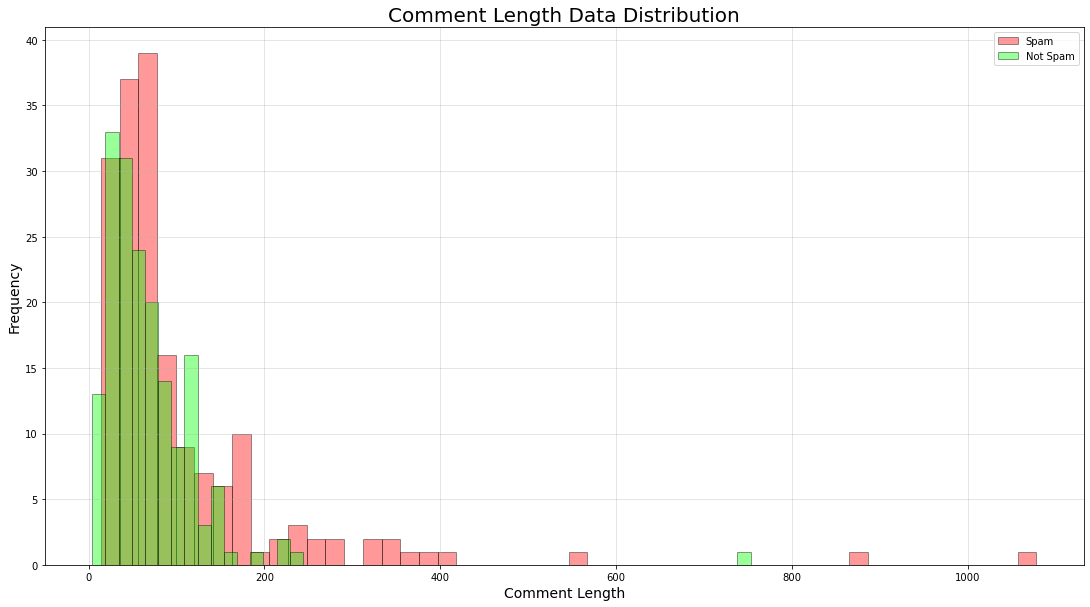

In [15]:
fig, ax = plt.subplots(figsize=(15,8))
ax.hist(x='CON_LEN', data=psy[psy['CLASS']==1], color='red', alpha=0.4, bins=50, label='Spam')
ax.hist(x='CON_LEN', data=psy[psy['CLASS']==0], color='lime', alpha=0.4, bins=50, label='Not Spam')
plt.tight_layout()
plt.title('Comment Length Data Distribution', fontsize=20)
plt.xlabel('Comment Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()

Text(0.5, 0, 'Comment Length')

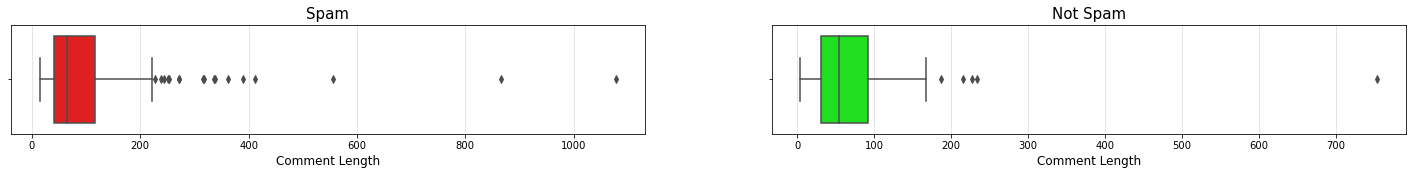

In [16]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25,2))
sns.boxplot(x='CON_LEN', data=psy[psy['CLASS']==1], color='red', ax=axs[0])
sns.boxplot(x='CON_LEN', data=psy[psy['CLASS']==0], color='lime', ax=axs[1])
axs[0].set_title('Spam', fontsize=15)
axs[1].set_title('Not Spam', fontsize=15)
axs[0].set_xlabel('Comment Length', fontsize=12)
axs[1].set_xlabel('Comment Length', fontsize=12)

**Author length data distribution.**

*However, not spam author's characters tend to have greater length than spam author's characters. This might indicate that author's character's length doesn't correlate to a comment classified as spam or not.*

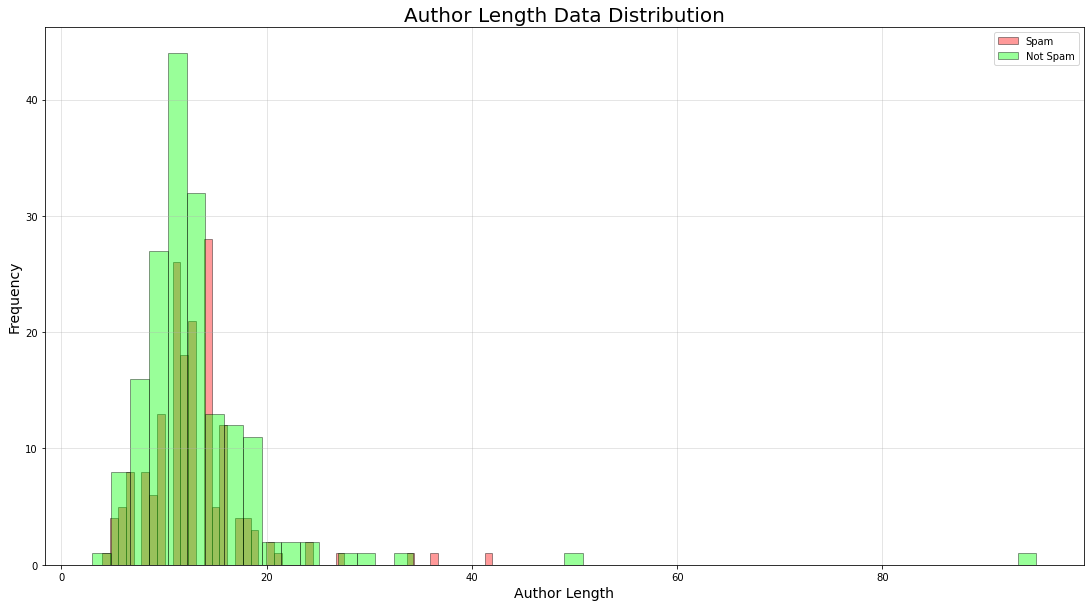

In [17]:
fig, ax = plt.subplots(figsize=(15,8))
ax.hist(x='AUT_LEN', data=psy[psy['CLASS']==1], color='red', alpha=0.4, bins=50, label='Spam')
ax.hist(x='AUT_LEN', data=psy[psy['CLASS']==0], color='lime', alpha=0.4, bins=50, label='Not Spam')
plt.tight_layout()
plt.title('Author Length Data Distribution', fontsize=20)
plt.xlabel('Author Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()

Text(0.5, 0, 'Author Length')

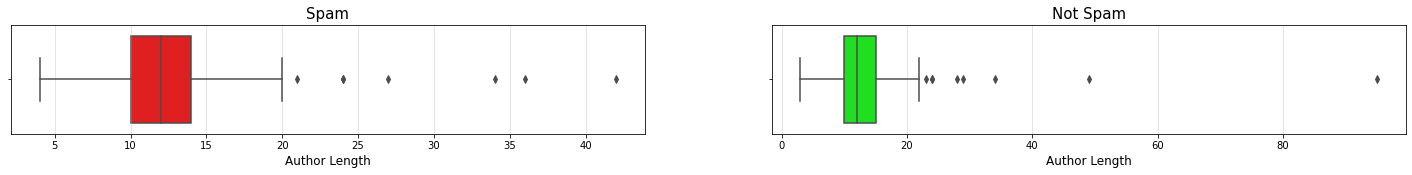

In [18]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25,2))
sns.boxplot(x='AUT_LEN', data=psy[psy['CLASS']==1], color='red', ax=axs[0])
sns.boxplot(x='AUT_LEN', data=psy[psy['CLASS']==0], color='lime', ax=axs[1])
axs[0].set_title('Spam', fontsize=15)
axs[1].set_title('Not Spam', fontsize=15)
axs[0].set_xlabel('Author Length', fontsize=12)
axs[1].set_xlabel('Author Length', fontsize=12)

**Classifiy the time as AM or PM.**

In [19]:
psy['TIME'] = psy['DATE'].apply(lambda x: x.hour)

In [20]:
psy.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CON_LEN,AUT_LEN,TIME
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07 06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,9,6
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07 12:37:15,Hey guys check out my new channel and our firs...,1,166,11,12
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08 17:34:21,just for test I have to say murdev.com,1,38,16,17
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09 08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48,15,8
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10 16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39,6,16


In [21]:
def time(x):
    if x > 11:
        return 'PM'
    else:
        return 'AM'

In [22]:
psy['TIME'] = psy['TIME'].apply(time)

In [23]:
psy.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CON_LEN,AUT_LEN,TIME
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07 06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,9,AM
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07 12:37:15,Hey guys check out my new channel and our firs...,1,166,11,PM
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08 17:34:21,just for test I have to say murdev.com,1,38,16,PM
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09 08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48,15,AM
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10 16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39,6,PM


**We can add another column for 'spam' or 'not spam' labels.**

In [24]:
def spamornot(label):
    if label == 1:
        return 'spam'
    else:
        return 'not spam'

In [25]:
psy['LABEL'] = psy['CLASS'].apply(spamornot)

In [26]:
psy.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CON_LEN,AUT_LEN,TIME,LABEL
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07 06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,9,AM,spam
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07 12:37:15,Hey guys check out my new channel and our firs...,1,166,11,PM,spam
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08 17:34:21,just for test I have to say murdev.com,1,38,16,PM,spam
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09 08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48,15,AM,spam
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10 16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39,6,PM,spam


**There is no time trend for each spam and not spam comments. And this dataset contains balanced labels.**

spam        175
not spam    175
Name: LABEL, dtype: int64

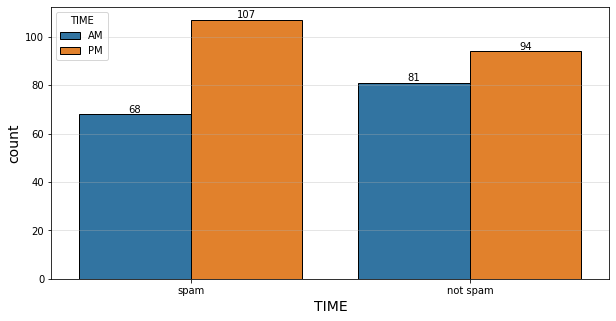

In [27]:
plt.figure(figsize=(10,5))
splot = sns.countplot(x='LABEL', data=psy, hue='TIME')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 4.7), 
                   textcoords = 'offset points')
    
plt.xlabel("TIME", size=14)
plt.ylabel("count", size=14)

psy['LABEL'].value_counts()

**However comments posted on PM time are more than comments posted on AM time.**

In [28]:
psy['TIME'].value_counts()

PM    201
AM    149
Name: TIME, dtype: int64

PM    201
AM    149
Name: TIME, dtype: int64

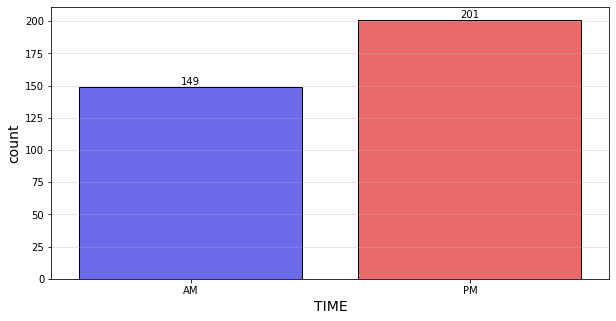

In [29]:
plt.figure(figsize=(10,5))
splot = sns.countplot(x='TIME', data=psy, palette='seismic')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 4.7), 
                   textcoords = 'offset points')
    
plt.xlabel("TIME", size=14)
plt.ylabel("count", size=14)

psy['TIME'].value_counts()

*Comments with greater lengths tend to be posted at PM rather than AM time.*

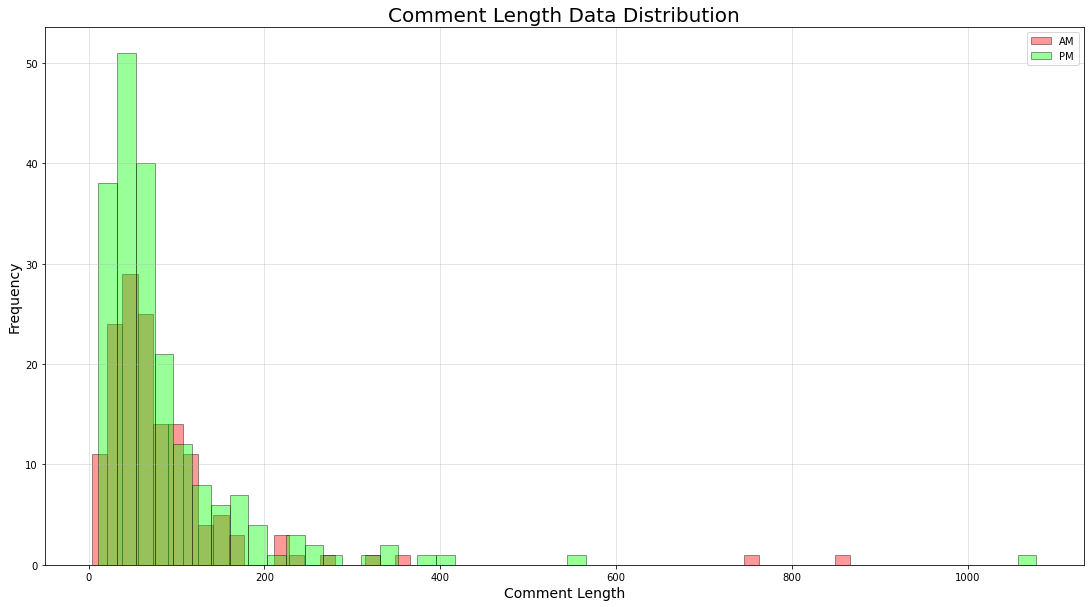

In [30]:
fig, ax = plt.subplots(figsize=(15,8))
ax.hist(x='CON_LEN', data=psy[psy['TIME']=='AM'], color='red', alpha=0.4, bins=50, label='AM')
ax.hist(x='CON_LEN', data=psy[psy['TIME']=='PM'], color='lime', alpha=0.4, bins=50, label='PM')
plt.tight_layout()
plt.title('Comment Length Data Distribution', fontsize=20)
plt.xlabel('Comment Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()

Text(0.5, 0, 'Comment Length')

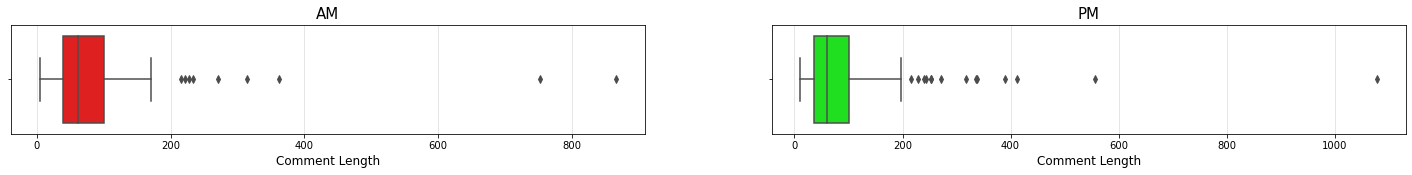

In [31]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25,2))
sns.boxplot(x='CON_LEN', data=psy[psy['TIME']=='AM'], color='red', ax=axs[0])
sns.boxplot(x='CON_LEN', data=psy[psy['TIME']=='PM'], color='lime', ax=axs[1])
axs[0].set_title('AM', fontsize=15)
axs[1].set_title('PM', fontsize=15)
axs[0].set_xlabel('Comment Length', fontsize=12)
axs[1].set_xlabel('Comment Length', fontsize=12)

### Text processing (tokenizing, vectorization, tf-idf).

**import string to remove the punctuation in the comments. And the stopwords function that is imported from nltk.corpus is to remove common words (i.e. our you, you're, how, all, etc.), so later the TF-IDF can get better result of the document's weight.**

**The text_process function will be used later in the pipeline method.**

In [32]:
def text_process(comment):
    nopunc = [char for char in comment if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

**Some example of common english words in stopwords.words corpus.**

In [33]:
stopwords.words('english')[99:109]

['once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both']

*Below is example of how text_process function above works. This is the tokenization step.*

In [34]:
psy['CONTENT'][0]

'Huh, anyway check out this you[tube] channel: kobyoshi02'

In [35]:
text_process(psy['CONTENT'][0])

['Huh', 'anyway', 'check', 'youtube', 'channel', 'kobyoshi02']

*And below is example of how CountVectorizer works.*

In [36]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(psy['CONTENT'])

In [37]:
print(bow_transformer.vocabulary_)

{'Huh': 213, 'anyway': 494, 'check': 572, 'youtube': 1434, 'channel': 569, 'kobyoshi02': 957, 'Hey': 210, 'guys': 792, 'new': 1060, 'first': 727, 'vid': 1343, 'US': 414, 'MONKEYS': 282, 'Im': 221, 'monkey': 1039, 'white': 1396, 'shirtplease': 1204, 'leave': 971, 'like': 975, 'comment': 596, 'please': 1117, 'subscribe': 1262, 'test': 1287, 'say': 1185, 'murdevcom': 1050, 'shaking': 1200, 'sexy': 1199, 'ass': 506, 'enjoy': 684, '\ufeff': 1450, 'watchvvtaRGgvGtWQ': 1382, 'Check': 115, 'website': 1386, 'site': 1219, 'kids': 948, 'stuff': 1255, 'kidsmediausa': 949, 'com': 591, 'Subscribe': 384, 'turned': 1324, 'mute': 1052, 'soon': 1234, 'came': 553, 'wanted': 1373, 'views\ufeff': 1358, 'Funny': 174, 'VIDEOS\ufeff': 421, 'u': 1331, 'shouldd': 1211, 'tell': 1286, 'next\ufeff': 1064, 'me\ufeff': 1020, 'started': 1247, 'reading': 1154, 'stop': 1251, 'within': 1403, 'one': 1086, 'day': 637, 'youre': 1433, 'entire': 687, 'family': 715, 'die': 648, 'want': 1372, 'stay': 1248, 'alive': 473, 'right

In [38]:
len(bow_transformer.vocabulary_)

1459

In [39]:
psy['CONTENT'][0]

'Huh, anyway check out this you[tube] channel: kobyoshi02'

In [40]:
psy['CONTENT'][0:1]

0    Huh, anyway check out this you[tube] channel: ...
Name: CONTENT, dtype: object

In [41]:
example = bow_transformer.transform(psy['CONTENT'][0:1])
print(example)
# If we state psy['CONTENT'][0] error message will appear. It expects iterable over raw text documents, instead
# of string object.

  (0, 213)	1
  (0, 494)	1
  (0, 569)	1
  (0, 572)	1
  (0, 957)	1
  (0, 1434)	1


*This cell below shows how to get Bag of Words (bow) of entire CONTENT.*

In [42]:
content_bow = bow_transformer.transform(psy['CONTENT'])

In [43]:
print('Shape of Sparse Matrix: ', content_bow.shape)
print()
print('Amount of Non-Zero occurences: ', content_bow.nnz)

Shape of Sparse Matrix:  (350, 1459)

Amount of Non-Zero occurences:  2671


In [44]:
sparsity = (100.0 * content_bow.nnz / (content_bow.shape[0] * content_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 1


*These cells below will show example of how TF-IDF works.*

In [45]:
tfidf_transformer = TfidfTransformer().fit(content_bow)

In [46]:
# The (0, 1434) is the word vector. While 0.35164.. is the measure of the word's importance in document (particular-
# comment), and in the corpus (all of the comments) as well.
tfidf_example = tfidf_transformer.transform(example)
print(tfidf_example)

  (0, 1434)	0.3516436276659161
  (0, 957)	0.4956285772184817
  (0, 572)	0.25489293848539957
  (0, 569)	0.27282464948274626
  (0, 494)	0.4956285772184817
  (0, 213)	0.4956285772184817


In [47]:
text_process(psy['CONTENT'][0:1].values[0])

['Huh', 'anyway', 'check', 'youtube', 'channel', 'kobyoshi02']

*Below is the IDF (inverse document frequency) of the word "anyway", and "channel". IDF shows importance level of the word in the entire contents (all comments). While TF (term Frequency) is the importance level of the word in a document (or in a comment).*

In [48]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['anyway']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['channel']])

6.167639042905921
3.3950503206661393


*TF-IDF.transform on all the comments.*

In [49]:
content_tfidf = tfidf_transformer.transform(content_bow)

In [50]:
print(content_tfidf)

  (0, 1434)	0.3516436276659161
  (0, 957)	0.4956285772184817
  (0, 572)	0.25489293848539957
  (0, 569)	0.27282464948274626
  (0, 494)	0.4956285772184817
  (0, 213)	0.4956285772184817
  (1, 1396)	0.29520071219022825
  (1, 1343)	0.29520071219022825
  (1, 1262)	0.17626602622033774
  (1, 1204)	0.29520071219022825
  (1, 1117)	0.19277107076609976
  (1, 1060)	0.20561094666461335
  (1, 1039)	0.29520071219022825
  (1, 975)	0.16720836693110738
  (1, 971)	0.2757940011539378
  (1, 792)	0.20561094666461335
  (1, 727)	0.2352399203973389
  (1, 596)	0.22884872890116148
  (1, 572)	0.1518164618259711
  (1, 569)	0.1624967456120948
  (1, 414)	0.2620247205456949
  (1, 282)	0.29520071219022825
  (1, 221)	0.20206392875280557
  (1, 210)	0.20206392875280557
  (2, 1287)	0.5899894581810486
  :	:
  (347, 765)	0.3258606160169376
  (347, 673)	0.3827189778421996
  (347, 551)	0.3827189778421996
  (347, 511)	0.3827189778421996
  (347, 194)	0.3827189778421996
  (348, 1288)	0.30351006598094615
  (348, 1117)	0.2411525860

*We can transform the matrix into array form, if later we would want to put the tf-idf into the dataframe.*

In [51]:
tfidf_arr = content_tfidf.toarray()
tfidf_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [52]:
temp = pd.DataFrame(data=tfidf_arr).iloc[:,1450:1451]
np.unique(temp)

array([0.        , 0.05720282, 0.07691616, 0.07894442, 0.08671103,
       0.09196289, 0.10078373, 0.11904538, 0.12249699, 0.12353424,
       0.12632722, 0.12765594, 0.13936254, 0.14136526, 0.14811941,
       0.14863277, 0.15598012, 0.15664249, 0.1613331 , 0.16469348,
       0.16717997, 0.17183406, 0.17239547, 0.17690497, 0.17964832,
       0.18105591, 0.18438285, 0.18829017, 0.19747017, 0.21294862,
       0.21446301, 0.21609856, 0.21629488, 0.21707026, 0.21734154,
       0.22333263, 0.23608396, 0.23994047, 0.241776  , 0.25422496,
       0.25516172, 0.25732061, 0.27277771, 0.27587635, 0.2943457 ,
       0.2958024 , 0.29607026, 0.31342468, 0.31892575, 0.33038659,
       0.33656135, 0.36439374, 0.38325106, 0.3993282 , 0.41648664,
       0.44053062, 0.58932586])

In [53]:
temp2 = pd.DataFrame(data=tfidf_arr).iloc[:,1451:1452]
np.unique(temp2)

array([0.        , 0.37796447])

In [54]:
tfidf_df = pd.DataFrame(data=tfidf_arr)
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.217070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.336561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*We can try to make a simple prediction of the output of an existing comment.*

In [55]:
spam_detect_model = MultinomialNB().fit(content_tfidf, psy['CLASS'])

*This is the document which outcome we would like to try to predict.*

In [56]:
text_process(psy['CONTENT'][0])

['Huh', 'anyway', 'check', 'youtube', 'channel', 'kobyoshi02']

In [57]:
coba = bow_transformer.transform(psy['CONTENT'][0:1])
tfidf_coba = tfidf_transformer.transform(coba)

In [58]:
print('predicted:', spam_detect_model.predict(tfidf_coba)[0])
print('expected:', psy['CLASS'][0])

predicted: 1
expected: 1


In [59]:
spam_detect_model.predict(tfidf_coba)

array([1], dtype=int64)

## Building predictive model using machine learning.

**Split data into train and test data.**

In [60]:
X = psy['CONTENT']
y = psy['CLASS']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=421)

**Using pipeline method to create a package of methods that needed for building the model (except the data split which has been done above).**

**'bow' represents the CountVectorizer method, and it takes text_process function as the analyzer argument. It removes the punctuation, and common words from the document (comment). And then the CountVectorizer transforms the document from string to a vector.**

**'tfidf' represents the TF-IDF method. It determines the weigh of the document, based off of the document vector.**

**'classifier' represents the Naive-Bayes(NB) machine learning method. The NB type used here is the MultinomialNB.**

In [62]:
pipe = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

**The fit method will apply three of the methods above on the training dataset.**

In [63]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000016C60C8A558>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

**Create predictions object as the prediction based off of the test dataset.**

In [64]:
predictions = pipe.predict(X_test)

In [65]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90        37
           1       0.86      0.94      0.90        33

    accuracy                           0.90        70
   macro avg       0.90      0.90      0.90        70
weighted avg       0.90      0.90      0.90        70



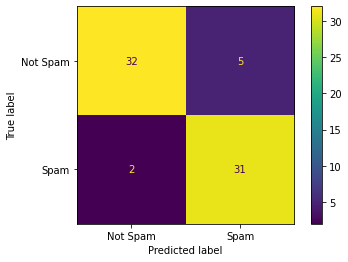

In [66]:
plt.rcParams['axes.grid']=False
plot_confusion_matrix(pipe,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['Not Spam', 'Spam']) # 0: Not Spam, 1: Spam
plt.rcParams['axes.grid']=True

**By looking at the ROC_AUC below, the model doesn't seem to over-fit. However, there could be other way that can be done to have a better predictive model.**

No Skill: ROC AUC = 0.500
Multinomial NB: ROC AUC = 0.977



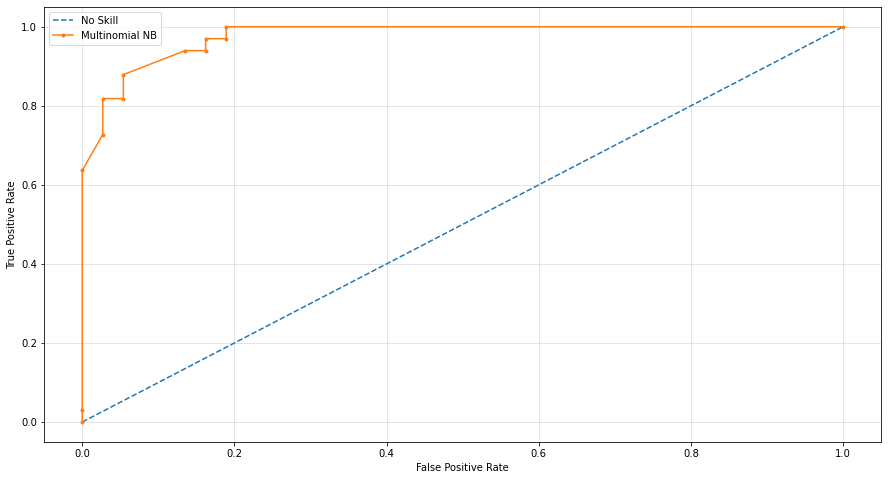

In [67]:
plt.rcParams['axes.grid']=True

pipe_probs = pipe.predict_proba(X_test)
pipe_probs = pipe_probs[:,1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
pipe_auc = roc_auc_score(y_test, pipe_probs)
print('No Skill: ROC AUC = %.3f' % (ns_auc))
print('Multinomial NB: ROC AUC = %.3f' % (pipe_auc))
print()
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pipe_fpr, pipe_tpr, _ = roc_curve(y_test, pipe_probs)
# plot the roc curve for the model
plt.figure(figsize=(15,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(pipe_fpr, pipe_tpr, marker='.', label='Multinomial NB')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

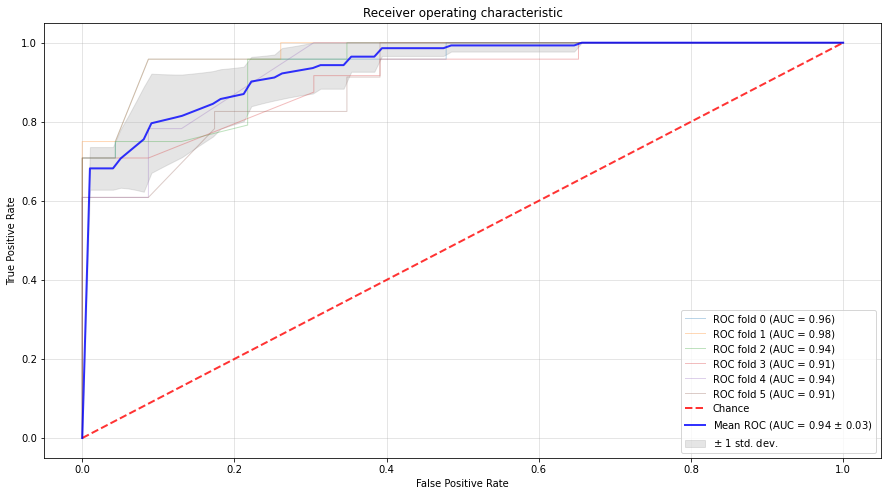

In [68]:
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(15,8))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    pipe.fit(X_train[train], y_train[train])
    viz = plot_roc_curve(pipe, X_train[test], y_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.show()

**We will use decision-tree based machine learning algorithms such as RandomForestClassifier or XGBoostClassifier to create a predictive model. But this time, we will put other variables too such as LENGTH, and TIME into the algorithm.**

*We have created dataframe that contains array form of tf-idf. Now we'll concatinate that dataframe with psy dataframe.*

In [69]:
psy2 = psy.copy()

In [70]:
psy2 = pd.concat([psy2, tfidf_df], axis=1)
psy2

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CON_LEN,AUT_LEN,TIME,LABEL,0,...,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07 06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,9,AM,spam,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07 12:37:15,Hey guys check out my new channel and our firs...,1,166,11,PM,spam,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08 17:34:21,just for test I have to say murdev.com,1,38,16,PM,spam,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09 08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48,15,AM,spam,0.0,...,0.0,0.217070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10 16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39,6,PM,spam,0.0,...,0.0,0.336561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,z13th1q4yzihf1bll23qxzpjeujterydj,Carmen Racasanu,2014-11-14 13:27:52,How can this have 2 billion views when there's...,0,74,15,PM,not spam,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346,z13fcn1wfpb5e51xe04chdxakpzgchyaxzo0k,diego mogrovejo,2014-11-14 13:28:08,I don't now why I'm watching this in 2014﻿,0,42,15,PM,not spam,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
347,z130zd5b3titudkoe04ccbeohojxuzppvbg,BlueYetiPlayz -Call Of Duty and More,2015-05-23 13:04:32,subscribe to me for call of duty vids and give...,1,67,36,PM,spam,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
348,z12he50arvrkivl5u04cctawgxzkjfsjcc4,Photo Editor,2015-06-05 14:14:48,hi guys please my android photo editor downloa...,1,128,12,PM,spam,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*The TIME variable still contains string data. We will convert it to integer, by changing the AM or PM values to 0 or 1 values.*

In [71]:
psy2.iloc[:,:9].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   COMMENT_ID  350 non-null    object        
 1   AUTHOR      350 non-null    object        
 2   DATE        350 non-null    datetime64[ns]
 3   CONTENT     350 non-null    object        
 4   CLASS       350 non-null    int64         
 5   CON_LEN     350 non-null    int64         
 6   AUT_LEN     350 non-null    int64         
 7   TIME        350 non-null    object        
 8   LABEL       350 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 24.7+ KB


In [72]:
time = pd.get_dummies(psy2['TIME'], prefix='time', drop_first=True)
time

,time_PM
0,0
1,1
2,1
3,0
4,1
...,...
345,1
346,1
347,1
348,1


In [73]:
psy2['TIME'] = time.values
psy2.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,CON_LEN,AUT_LEN,TIME,LABEL,0,...,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07 06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56,9,0,spam,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07 12:37:15,Hey guys check out my new channel and our firs...,1,166,11,1,spam,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08 17:34:21,just for test I have to say murdev.com,1,38,16,1,spam,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09 08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48,15,0,spam,0.0,...,0.0,0.217070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10 16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39,6,1,spam,0.0,...,0.0,0.336561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
psy2.drop(['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'LABEL'], axis=1, inplace=True)
psy2.head()

,CLASS,CON_LEN,AUT_LEN,TIME,0,1,2,3,4,5,...,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458
0,1,56,9,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,166,11,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,38,16,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,48,15,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.217070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,39,6,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.336561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
X = psy2.drop(['CLASS'], axis=1)
y = psy2['CLASS']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=421)

*We can use GridSearchCV or RandomizedSearchCV as well for hyperparameter tuning. However, this is just a preliminary actions and this is done just to show the difference between using the Multinomial Naive-Bayes machine learning algorithm and decision tree machine learning algorithm (the XGBoost type).*

In [77]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, random_state=421)
clf_xgb.fit(X_train, y_train, verbose=False, eval_metric='auc', early_stopping_rounds=10, eval_set=[(X_test, y_test)])

XGBClassifier(n_jobs=-1, random_state=421)

In [78]:
predictions = clf_xgb.predict(X_test)

In [79]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.73      0.82        37
           1       0.76      0.94      0.84        33

    accuracy                           0.83        70
   macro avg       0.84      0.83      0.83        70
weighted avg       0.85      0.83      0.83        70



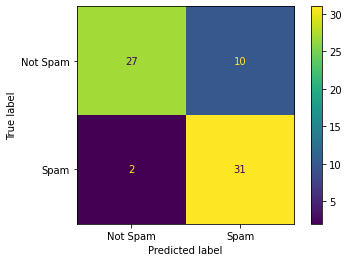

In [80]:
plt.rcParams['axes.grid']=False
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['Not Spam', 'Spam']) # 0: Not Spam, 1: Spam
plt.rcParams['axes.grid']=True

**The model doesn't seem to over-fit.**

No Skill: ROC AUC = 0.500
Multinomial NB: ROC AUC = 0.912



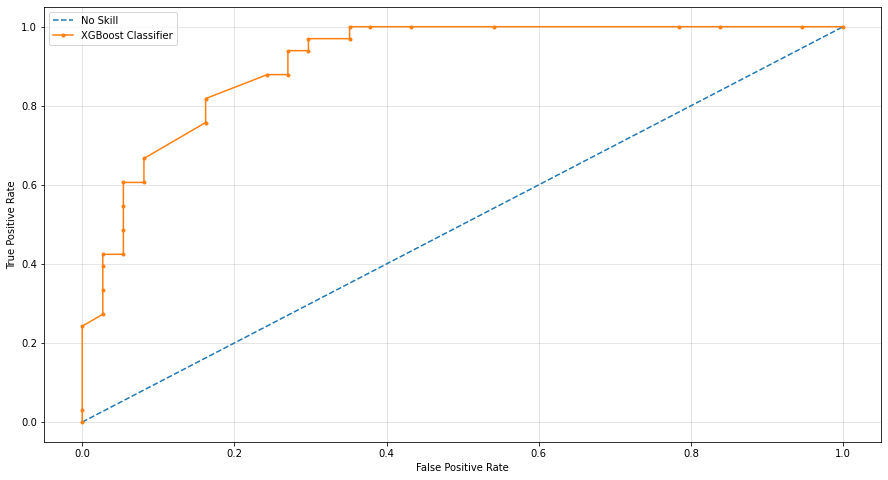

In [81]:
plt.rcParams['axes.grid']=True

clf_xgb_probs = clf_xgb.predict_proba(X_test)
clf_xgb_probs = clf_xgb_probs[:,1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
clf_xgb_auc = roc_auc_score(y_test, clf_xgb_probs)
print('No Skill: ROC AUC = %.3f' % (ns_auc))
print('Multinomial NB: ROC AUC = %.3f' % (clf_xgb_auc))
print()
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
clf_xgb_fpr, clf_xgb_tpr, _ = roc_curve(y_test, clf_xgb_probs)
# plot the roc curve for the model
plt.figure(figsize=(15,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(clf_xgb_fpr, clf_xgb_tpr, marker='.', label='XGBoost Classifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

**The ROC_AUC's accross folds show that the model doesn't over-fit. However using all of those variables other than tf-idf doesn't seem to show model improvement. Perhaps it's better to use just the tf-idf, or maybe do Natural Language Processing method also on the Author names.**

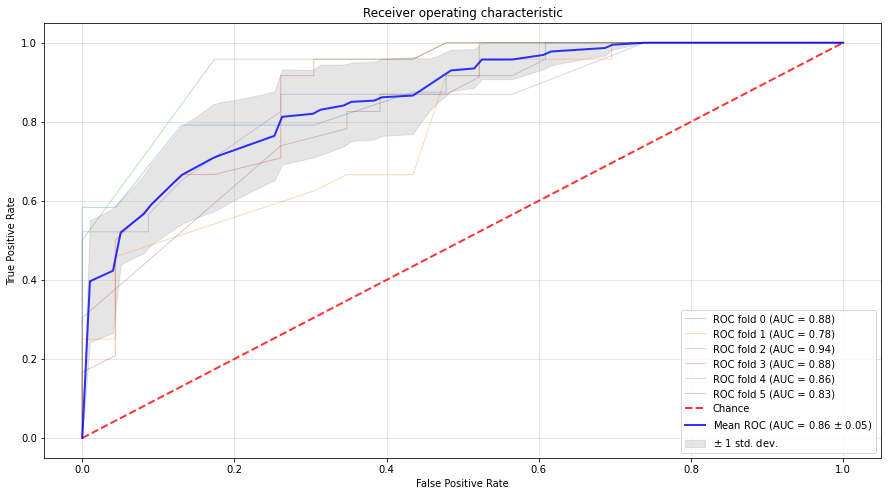

In [82]:
model = clf_xgb
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(15,8))
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    model.fit(X_train[train], y_train[train], verbose=False, eval_metric='auc', early_stopping_rounds=10, eval_set=[(X_test, y_test)])
    viz = plot_roc_curve(model, X_train[test], y_train[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.show()

(end of notebook).